In [2]:
from scipy.stats import ttest_rel
import pandas as pd
import numpy as np
from scipy.stats import norm, wasserstein_distance
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

mkdir -p failed for path /home/dev/.cache/matplotlib: [Errno 13] Permission denied: '/home/dev/.cache/matplotlib'
Matplotlib created a temporary cache directory at /tmp/matplotlib-s16li1t1 because there was an issue with the default path (/home/dev/.cache/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
# Use storm_data_with_priors so Heston/Merton use rolling priors (h_*, m_*) from fit_classics
df = pd.read_csv('storm_data_with_priors.csv')
market_col = "opt_price"

# Model columns and display names (canonical order for tables)
model_cols = ["V", "BS_V", "Heston_V", "Merton_V"]
model_names = ["qStorm", "BSM", "Heston", "Merton"]

In [4]:
# remove column cap and display all columns
pd.set_option('display.max_columns', None)
df.sample(5)

,date,index,ticker,S_prime,K,t_prime,S,volume,opt_price_prime,opt_price,best_bid,best_offer,volatility,rf,idx,V,V_prime,V_prime_delta,V_delta,BS_V,BS_V_prime,h_kappa,h_theta,h_sigma,h_rho,h_v0,m_sigma,m_lam,m_mu_j,m_sig_j
203442,2023-05-03,4301466,PFE,0.089119,360.0,16,32.082867,3,0.006861,2.470,2.44,2.50,0.012835,0.000142,22,0.659077,0.001831,0.005442,1.958958,0.0,0.0,6.539153,0.050444,0.449749,-0.019026,0.020743,0.189544,79.998618,0.001651,0.016335
239643,2023-06-30,4313258,PFE,0.084759,365.0,7,30.937151,1915,0.001247,0.455,0.45,0.46,0.012638,0.000141,0,0.378357,0.001037,0.002621,0.956677,0.0,0.0,10.598298,0.052063,0.549625,0.107563,0.050630,0.167296,79.998635,0.005186,0.017593
315180,2023-06-09,5723370,GME,0.058154,390.0,21,22.680000,0,0.000282,0.110,0.07,0.15,0.056548,0.000140,30,0.940479,0.002411,0.007546,2.943066,0.0,0.0,19.972366,0.619409,3.236851,0.242830,0.833805,0.726844,0.946419,0.303563,0.000001
185760,2023-01-20,5677685,GME,0.049025,400.0,14,19.610001,1206,0.000262,0.105,0.10,0.11,0.048822,0.000124,0,0.562233,0.001406,0.003759,1.503741,0.0,0.0,6.178132,0.898016,2.186341,0.306972,0.712532,0.861152,3.106264,0.244044,0.000001
339394,2023-08-17,3463899,MCD,0.090131,2950.0,22,265.887482,23,0.000134,0.395,0.36,0.43,0.007090,0.000145,13,8.510638,0.002885,0.009549,28.170359,0.0,0.0,5.893571,0.022276,0.298822,0.169330,0.014025,0.117533,79.999188,0.000839,0.011404


In [5]:
# Compute Heston and Merton option prices (European calls)
# Uses rolling priors (h_*, m_*) from storm_data_with_priors when available; fallback to defaults
HESTON_SAMPLE = None  # Set to int (e.g. 5000) for faster testing; None for full dataset
import QuantLib as ql
from scipy.special import factorial
from tqdm import tqdm

tick = 0.01
T_years = df["t_prime"].values / 365.0
r_annual = df["rf"].values * 365.0
sigma_annual = np.maximum(df["volatility"].values * np.sqrt(365.0), 1e-8)
S_vals = df["S"].values
K_vals = df["K"].values

# Prior columns (from fit_classics); fallbacks when missing or NaN
def _prior_col(name, default_arr):
    if name not in df.columns:
        return default_arr
    v = df[name].values
    return np.where(np.isfinite(v), v, default_arr)

# Merton priors: m_sigma (diffusion vol), m_lam, m_mu_j, m_sig_j
m_sigma = _prior_col("m_sigma", sigma_annual)
m_lam = _prior_col("m_lam", np.full(len(df), 0.1))
m_mu_j = _prior_col("m_mu_j", np.full(len(df), -0.1))
m_sig_j = _prior_col("m_sig_j", np.full(len(df), 0.2))

def black_scholes_call(S, K, T, r, sigma):
    """Vectorized Black-Scholes European call."""
    T_safe = np.maximum(T, 1e-10)
    sigma_safe = np.maximum(sigma, 1e-10)
    d1 = (np.log(S / K) + (r + 0.5 * sigma_safe**2) * T_safe) / (sigma_safe * np.sqrt(T_safe))
    d2 = d1 - sigma_safe * np.sqrt(T_safe)
    return S * norm.cdf(d1) - K * np.exp(-r * T_safe) * norm.cdf(d2)

def merton_call_vectorized(S, K, T, r, sigma, lam=0.1, mu_j=-0.1, sigma_j=0.2, k_max=15):
    """Merton jump-diffusion call price. lam, mu_j, sigma_j can be scalars or arrays."""
    lam = np.broadcast_to(np.atleast_1d(lam), S.shape).astype(float)
    mu_j = np.broadcast_to(np.atleast_1d(mu_j), S.shape).astype(float)
    sigma_j = np.broadcast_to(np.atleast_1d(sigma_j), S.shape).astype(float)
    m = np.exp(mu_j + 0.5 * sigma_j**2)
    T_safe = np.maximum(T, 1e-10)
    p = np.zeros_like(S, dtype=float)
    for k in range(k_max + 1):
        r_k = r - lam * (m - 1) + (k * np.log(m)) / T_safe
        sigma_k = np.sqrt(np.maximum(sigma**2 + (k * sigma_j**2) / T_safe, 1e-12))
        prob = np.exp(-lam * T_safe) * (lam * T_safe)**k / factorial(k)
        p += prob * black_scholes_call(S, K, T_safe, r_k, sigma_k)
    return p

# Merton (vectorized, per-row priors)
df["Merton_V"] = merton_call_vectorized(S_vals, K_vals, T_years, r_annual, m_sigma, lam=m_lam, mu_j=m_mu_j, sigma_j=m_sig_j)

# Heston (QuantLib, looped). Use prior columns h_kappa, h_theta, h_sigma, h_rho, h_v0 when present.
def heston_price(S, K, T, r, sigma, v0=None, kappa=2.0, theta=None, sigma_vol=0.3, rho=-0.7):
    if v0 is None:
        v0 = sigma**2
    if theta is None:
        theta = sigma**2
    if T <= 0 or sigma <= 0:
        return max(S - K, 0.0)
    try:
        today = ql.Date().todaysDate()
        ql.Settings.instance().evaluationDate = today
        risk_free = ql.YieldTermStructureHandle(ql.FlatForward(today, r, ql.Actual365Fixed()))
        dividend = ql.YieldTermStructureHandle(ql.FlatForward(today, 0.0, ql.Actual365Fixed()))
        spot = ql.QuoteHandle(ql.SimpleQuote(float(S)))
        process = ql.HestonProcess(risk_free, dividend, spot, v0, kappa, theta, sigma_vol, rho)
        model = ql.HestonModel(process)
        engine = ql.AnalyticHestonEngine(model)
        payoff = ql.PlainVanillaPayoff(ql.Option.Call, float(K))
        expiry = today + ql.Period(int(round(T * 365)), ql.Days)
        exercise = ql.EuropeanExercise(expiry)
        option = ql.VanillaOption(payoff, exercise)
        option.setPricingEngine(engine)
        return option.NPV()
    except Exception:
        return np.nan

# Prior arrays for Heston (fallback to volatility-based when NaN)
h_kappa = _prior_col("h_kappa", np.full(len(df), 2.0))
h_theta = _prior_col("h_theta", sigma_annual**2)
h_sigma = _prior_col("h_sigma", np.full(len(df), 0.3))
h_rho = _prior_col("h_rho", np.full(len(df), -0.7))
h_v0 = _prior_col("h_v0", sigma_annual**2)

indices = np.random.choice(len(df), HESTON_SAMPLE, replace=False) if HESTON_SAMPLE else np.arange(len(df))
heston_arr = np.full(len(df), np.nan, dtype=float)
for i in tqdm(indices, desc="Heston pricing"):
    s, k, t, r, sig = S_vals[i], K_vals[i], T_years[i], r_annual[i], sigma_annual[i]
    v0, kappa, theta, sigma_vol, rho = h_v0[i], h_kappa[i], h_theta[i], h_sigma[i], h_rho[i]
    heston_arr[i] = heston_price(s, k, t, r, sig, v0=v0, kappa=kappa, theta=theta, sigma_vol=sigma_vol, rho=rho)
df["Heston_V"] = heston_arr

Heston pricing: 100%|██████████| 354220/354220 [04:36<00:00, 1283.06it/s]


In [6]:
eps = 1e-12
tick = 0.01
delta = tick  # for log transform stability

df_eval = df.copy()
available_model_cols = [c for c in model_cols if c in df.columns]
available_model_names = [model_names[model_cols.index(c)] for c in available_model_cols]
need = ["ticker", market_col] + available_model_cols
df_eval = df_eval.dropna(subset=need)

def w1(a, b):
    a = np.asarray(a, float)
    b = np.asarray(b, float)
    a = a[np.isfinite(a)]
    b = b[np.isfinite(b)]
    if a.size == 0 or b.size == 0:
        return np.nan
    return float(wasserstein_distance(a, b))

def w1_log(a, b, delta=0.01):
    a = np.asarray(a, float)
    b = np.asarray(b, float)
    a = a[np.isfinite(a)]
    b = b[np.isfinite(b)]
    if a.size == 0 or b.size == 0:
        return np.nan
    return float(wasserstein_distance(np.log(a + delta), np.log(b + delta)))

rows = []
for ticker, g in df_eval.groupby("ticker"):
    market = g[market_col].to_numpy()
    row = {"ticker": ticker, "N": int(len(g))}
    for col, name in zip(available_model_cols, available_model_names):
        row[f"W1({name})"] = w1(g[col].to_numpy(), market)
        row[f"log-W1({name})"] = w1_log(g[col].to_numpy(), market, delta=delta)
    rows.append(row)

wd_df = pd.DataFrame(rows).set_index("ticker")

# Best model (lowest W1) vs BSM
w1_cols = [f"W1({n})" for n in available_model_names]
logw1_cols = [f"log-W1({n})" for n in available_model_names]
if "BSM" in available_model_names:
    wd_df["Δ W1 (best vs BSM)"] = wd_df["W1(BSM)"] - wd_df[w1_cols].min(axis=1)
    wd_df["Δ log-W1 (best vs BSM)"] = wd_df["log-W1(BSM)"] - wd_df[logw1_cols].min(axis=1)
    wd_df["% Improvement (W1)"] = 100 * (wd_df["W1(BSM)"] - wd_df[w1_cols].min(axis=1)) / wd_df["W1(BSM)"]
    wd_df["% Improvement (log-W1)"] = 100 * (wd_df["log-W1(BSM)"] - wd_df[logw1_cols].min(axis=1)) / wd_df["log-W1(BSM)"]

canonical_w1_cols = w1_cols + logw1_cols + ["N"]
if "BSM" in available_model_names:
    canonical_w1_cols += ["Δ W1 (best vs BSM)", "Δ log-W1 (best vs BSM)", "% Improvement (W1)", "% Improvement (log-W1)"]

wd_df.loc["Total"] = wd_df.mean(numeric_only=True)
wd_df.loc["Total", "N"] = wd_df["N"].sum()

wd_df[[c for c in canonical_w1_cols if c in wd_df.columns]]


,W1(qStorm),W1(BSM),W1(Heston),W1(Merton),log-W1(qStorm),log-W1(BSM),log-W1(Heston),log-W1(Merton),N,Δ W1 (best vs BSM),Δ log-W1 (best vs BSM),% Improvement (W1),% Improvement (log-W1)
ticker,,,,,,,,,,,,,
BB,0.890629,0.981159,0.982258,0.981979,1.399059,2.901989,2.912483,2.909321,19977.0,0.090530,1.502930,9.226810,51.789642
GME,2.578702,3.006156,3.006850,3.006871,1.330435,4.127686,4.130519,4.128060,59034.0,0.427454,2.797250,14.219278,67.768008
JPM,12.346149,14.184153,14.184153,14.184153,2.011655,5.376095,5.376095,5.376095,55075.0,1.838003,3.364440,12.958147,62.581482
MCD,28.600533,31.706261,31.706261,31.706261,2.391128,5.775518,5.775518,5.775518,54781.0,3.105728,3.384389,9.795316,58.598889
NKE,8.301995,9.707599,9.707599,9.707599,1.958597,4.855403,4.855403,4.855403,54256.0,1.405603,2.896807,14.479413,59.661501
NOK,0.966388,1.037638,1.037812,1.037781,1.663425,2.852769,2.860538,2.858774,18657.0,0.071251,1.189345,6.866625,41.690886
PFE,2.522730,2.908599,2.908599,2.908599,1.930401,3.616442,3.616442,3.616442,39700.0,0.385869,1.686041,13.266485,46.621528
XOM,8.963883,10.329900,10.329900,10.329900,1.969268,4.945884,4.945884,4.945884,52740.0,1.366017,2.976616,13.223916,60.183698
Total,8.146376,9.232683,9.232929,9.232893,1.831746,4.306473,4.309110,4.308187,398497.5,1.086307,2.474727,11.754499,56.111954


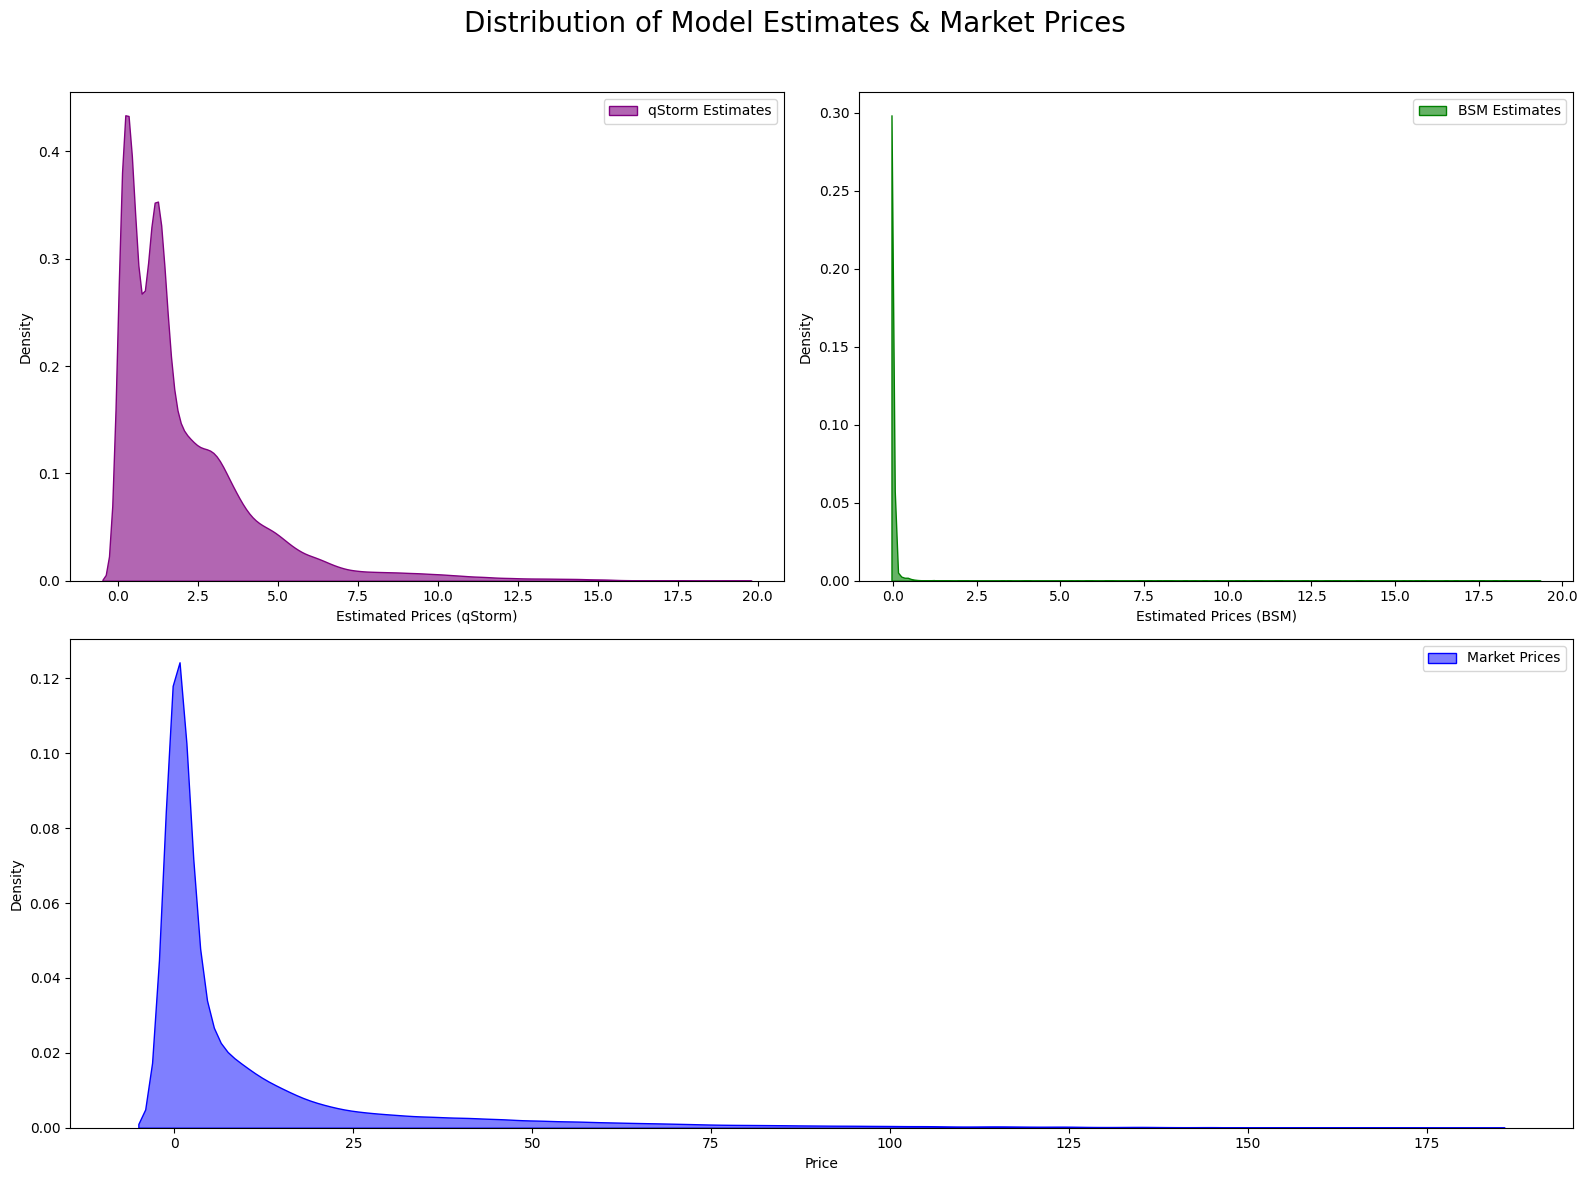

In [18]:
import seaborn as sns

model_estimates = df["V"]
bs_estimates = df["BS_V"]
market_prices = df[market_col]

plt.figure(figsize=(16, 12))
plt.suptitle("Distribution of Model Estimates & Market Prices", fontsize=20)

# Top left: qStorm Estimates
ax1 = plt.subplot(2, 2, 1)
sns.kdeplot(model_estimates, fill=True, color="purple", alpha=0.6, label='qStorm Estimates', ax=ax1)
plt.xlabel('Estimated Prices (qStorm)')
plt.ylabel('Density')
plt.legend()

# Top right: BSM Estimates
ax2 = plt.subplot(2, 2, 2)
sns.kdeplot(bs_estimates, fill=True, color="green", alpha=0.6, label='BSM Estimates', ax=ax2)
plt.xlabel('Estimated Prices (BSM)')
plt.ylabel('Density')
plt.legend()

# Bottom: Market Prices spanning whole bottom row
ax3 = plt.subplot(2, 1, 2)
sns.kdeplot(market_prices, fill=True, color="blue", alpha=0.5, label='Market Prices', ax=ax3)
plt.xlabel('Price')
plt.ylabel('Density')
plt.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("pics/model_estimates_market_prices.png")
plt.show()

In [10]:
# RMSE per ticker, both price and log-price errors, canonical columns

available_cols = [c for c in model_cols if c in df.columns]
available_names = [model_names[model_cols.index(c)] for c in available_cols]

rmse_rows = []
for ticker, sub_df in df.groupby("ticker"):
    sub_df = sub_df.dropna(subset=[market_col] + available_cols)
    if len(sub_df) == 0:
        continue
    row = {"ticker": ticker, "N": len(sub_df)}
    rmse_bsm = np.nan
    log_rmse_bsm = np.nan
    for col, name in zip(available_cols, available_names):
        # RMSE (normal)
        err = (sub_df[market_col] - sub_df[col]) ** 2
        rmse_val = np.sqrt(err.mean())
        row[f"RMSE({name})"] = rmse_val

        # RMSE (log)
        log_err = (np.log(sub_df[market_col] + tick) - np.log(sub_df[col] + tick)) ** 2
        log_rmse_val = np.sqrt(log_err.mean())
        row[f"log-RMSE({name})"] = log_rmse_val

        if col == "BS_V":
            rmse_bsm = rmse_val
            log_rmse_bsm = log_rmse_val

    # % Improvement for price RMSE
    if rmse_bsm > 0 and rmse_bsm == rmse_bsm:
        best_rmse = min(row[f"RMSE({n})"] for n in available_names)
        row["% Improvement vs BSM (RMSE)"] = 100 * (rmse_bsm - best_rmse) / rmse_bsm

    # % Improvement for log price RMSE
    if log_rmse_bsm > 0 and log_rmse_bsm == log_rmse_bsm:
        best_log_rmse = min(row[f"log-RMSE({n})"] for n in available_names)
        row["% Improvement vs BSM (log-RMSE)"] = 100 * (log_rmse_bsm - best_log_rmse) / log_rmse_bsm

    rmse_rows.append(row)

rmse_df = pd.DataFrame(rmse_rows).set_index("ticker")
rmse_df.loc["Total"] = rmse_df.mean(numeric_only=True)
rmse_df.loc["Total", "N"] = rmse_df["N"].sum()
rmse_df = round(rmse_df, 4)

canonical_rmse_cols = (
    [f"RMSE({n})" for n in available_names] +
    [f"log-RMSE({n})" for n in available_names] +
    ["% Improvement vs BSM (RMSE)", "% Improvement vs BSM (log-RMSE)", "N"]
)
rmse_df[[c for c in canonical_rmse_cols if c in rmse_df.columns]]

,RMSE(qStorm),RMSE(BSM),RMSE(Heston),RMSE(Merton),log-RMSE(qStorm),log-RMSE(BSM),log-RMSE(Heston),log-RMSE(Merton),% Improvement vs BSM (RMSE),% Improvement vs BSM (log-RMSE),N
ticker,,,,,,,,,,,
BB,1.5905,1.6560,1.6587,1.6580,2.3750,3.5364,3.5488,3.5449,3.9514,32.8415,19977.0
GME,5.1796,5.3655,5.3680,5.3679,2.3466,4.6170,4.6202,4.6167,3.4656,49.1744,59034.0
JPM,22.2767,23.4728,23.4728,23.4728,2.9150,6.0583,6.0583,6.0583,5.0957,51.8849,55075.0
MCD,48.5131,51.0451,51.0451,51.0451,3.2501,6.5526,6.5526,6.5526,4.9605,50.3990,54781.0
NKE,16.2696,17.1955,17.1955,17.1955,2.8759,5.5809,5.5809,5.5809,5.3850,48.4697,54256.0
NOK,1.6549,1.7156,1.7160,1.7160,2.5650,3.6407,3.6522,3.6495,3.5389,29.5467,18657.0
PFE,4.9888,5.3057,5.3057,5.3057,2.7167,4.4036,4.4036,4.4036,5.9717,38.3065,39700.0
XOM,17.1715,18.0426,18.0426,18.0426,2.8713,5.6525,5.6525,5.6525,4.8284,49.2038,52740.0
Total,14.7056,15.4749,15.4756,15.4755,2.7394,5.0052,5.0086,5.0074,4.6496,43.7283,398497.5
